## VGG16 based network
This time we will play around with VGG16 model, which has won ImageNet Challenge 2014 for localization. You can find the paper [here](https://arxiv.org/abs/1409.1556)

In [62]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let us first try with small sample of data and later increase the dataset with lot of data. 

Notice the difference. 

In [63]:
import os
import numpy as np
import keras
from keras.models import Sequential 
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import * 
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from keras.preprocessing import image


TRAIN = 'sample-dog-cat/train'
VALID = 'sample-dog-cat/valid'
TEST  = 'sample-dog-cat/test'

#TRAIN = 'dogscats/train'
#VALID = 'dogscats/valid'
#TEST  = 'dogscats/test'

# Enable TensorBoard
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)


In [64]:
import tensorflow as tf
import random as rn

os.environ['PYTHONHASHSEED'] = '0'

# Setting the seed for numpy-generated random numbers
np.random.seed(37)

# Setting the seed for python random numbers
rn.seed(1254)

# Setting the graph-level random seed.
tf.set_random_seed(89)

from keras import backend as K

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess)

In [65]:
train_batch = ImageDataGenerator().flow_from_directory(TRAIN, target_size=(224,224), classes=['dogs', 'cats'], batch_size=8)
valid_batch = ImageDataGenerator().flow_from_directory(VALID, target_size=(224,224), classes=['dogs', 'cats'], batch_size=4)
test_batch = ImageDataGenerator().flow_from_directory(TEST, target_size=(224,224), classes=['dogs', 'cats'], batch_size=8)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [66]:
os.listdir(TRAIN)

['dogs', 'cats']

In [67]:
file = os.listdir('sample-dog-cat/train/cats/')[0:5]
file

['cat.9021.jpg',
 'cat.9342.jpg',
 'cat.5999.jpg',
 'cat.2784.jpg',
 'cat.9084.jpg']

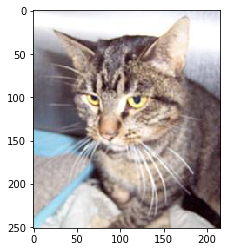

In [68]:
img = plt.imread('sample-dog-cat/train/cats/cat.9021.jpg')
plt.imshow(img);

In [69]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [70]:
imgs, labels = next(train_batch)

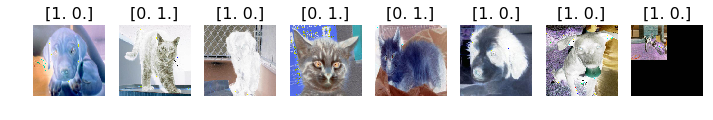

In [71]:
plots(imgs, titles=labels)

In [72]:
vgg_model = keras.applications.vgg16.VGG16(weights='imagenet')

In [73]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [74]:
type(vgg_model)

keras.engine.training.Model

In [75]:
model = Sequential()
for layer in vgg_model.layers:
    model.add(layer)

In [76]:
type(model)

keras.models.Sequential

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [79]:
for layer in model.layers:
    layer.trainable = False

In [80]:
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [81]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=(['accuracy']))

In [82]:
model.fit_generator(train_batch, steps_per_epoch=4, validation_data=valid_batch, validation_steps=4, epochs=3, verbose=2, callbacks=[tbCallBack])

Epoch 1/3
 - 34s - loss: 0.7006 - acc: 0.3125 - val_loss: 0.6914 - val_acc: 0.6250
Epoch 2/3
 - 29s - loss: 0.6883 - acc: 0.6562 - val_loss: 0.6858 - val_acc: 0.7500
Epoch 3/3
 - 29s - loss: 0.6801 - acc: 0.8125 - val_loss: 0.6795 - val_acc: 0.7500


In [83]:
tst_imgs, tst_labels = next(test_batch)

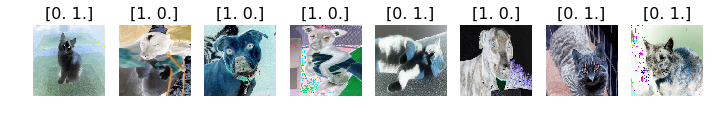

In [84]:
plots(tst_imgs, titles=tst_labels)

In [85]:
tst_labels = tst_labels[:,0]
tst_labels

array([0., 1., 1., 1., 0., 1., 0., 0.], dtype=float32)

In [86]:
predictions = model.predict_generator(test_batch, steps=1, verbose=0)

In [87]:
predictions

array([[0.494774  , 0.505226  ],
       [0.5126777 , 0.48732233],
       [0.5212779 , 0.47872207],
       [0.5169043 , 0.48309574],
       [0.4893562 , 0.5106438 ],
       [0.51394033, 0.48605964],
       [0.49023992, 0.5097601 ],
       [0.49092558, 0.50907445]], dtype=float32)

In [88]:
cm = confusion_matrix(tst_labels, np.round(predictions[:,0]))

In [89]:
cm_plot_labels = ['cats', 'dogs']

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 0]
 [0 4]]


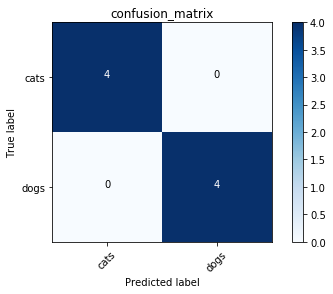

In [91]:
plot_confusion_matrix(cm, cm_plot_labels, title='confusion_matrix')